In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

BP_PRIMARY = "#0c7eab"
BP_SECONDARY = "#219955"
BP_ACCENT = '#d4a017'
BP_LIGHT = "#6a93c1"

REQ_PRIMARY = '#c0392b'
REQ_SECONDARY = '#e74c3c'
REQ_LIGHT = '#f1948a'

MDS_PRIMARY = '#6c3483'
MDS_SECONDARY = '#8e44ad'
MDS_LIGHT = '#bb8fce'

# Referências externas
REF_DECIDIM = '#2ecc71'     
REF_VSCODE = '#e67e22'  
REF_LIMIT = '#7f8c8d'

INPUT_FILE = 'prs.csv'

df_raw = pd.read_csv(INPUT_FILE)
df = df_raw[(df_raw['org'] == 'lappis-unb') & (df_raw['repo'] == 'brasilparticipativo')].copy()
org_title = "Brasil Participativo"

df_mds = df_raw[df_raw['org'] == 'unb-mds'].copy()
df_req = df_raw[df_raw['org'] == 'mdsreq-fga-unb'].copy()
df_decidim = df_raw[(df_raw['org'] == 'decidim')].copy()
df_vscode = df_raw[(df_raw['org'] == 'microsoft')].copy()
mds_title = "MDS (unb-mds)"
req_title = "REQ (mdsreq-fga-unb)"

print(f"Brasil Participativo: {len(df)} registros")
print(f"MDS: {len(df_mds)} registros")
print(f"REQ: {len(df_req)} registros")
print(f"Decidim (benchmark): {len(df_decidim)} registros")
print(f"VSCode (benchmark): {len(df_vscode)} registros")

Brasil Participativo: 510 registros
MDS: 1046 registros
REQ: 452 registros
Decidim (benchmark): 2172 registros
VSCode (benchmark): 15035 registros


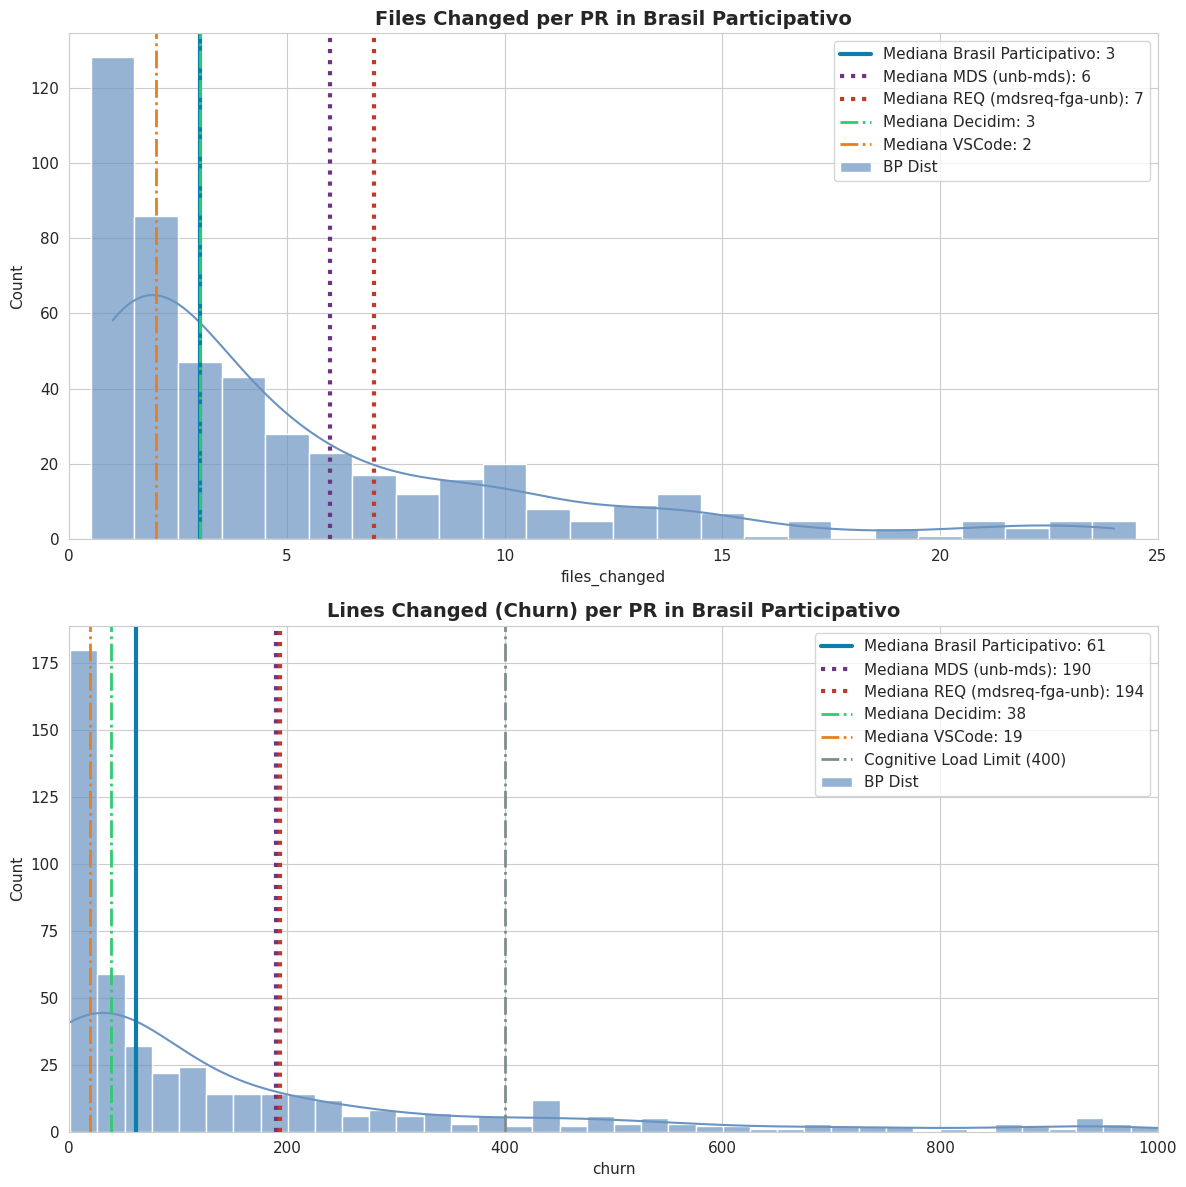

In [54]:
def plot_size_complexity_multi_bench(df_lab, df_mds, df_req, lab_label="BP", mds_label="MDS", req_label="Req"):
    clean_lab = df_lab[(df_lab['files_changed'] > 0) & (df_lab['churn'] > 0)].copy()
    clean_mds = df_mds[(df_mds['files_changed'] > 0) & (df_mds['churn'] > 0)].copy()
    clean_req = df_req[(df_req['files_changed'] > 0) & (df_req['churn'] > 0)].copy()
    clean_decidim = df_decidim[(df_decidim['files_changed'] > 0) & (df_decidim['churn'] > 0)].copy()
    clean_vscode = df_vscode[(df_vscode['files_changed'] > 0) & (df_vscode['churn'] > 0)].copy()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    p50_files_lab = clean_lab['files_changed'].median()
    p50_files_mds = clean_mds['files_changed'].median()
    p50_files_req = clean_req['files_changed'].median()
    p50_files_decidim = clean_decidim['files_changed'].median()
    p50_files_vscode = clean_vscode['files_changed'].median()
    p50_churn_lab = clean_lab['churn'].median()
    p50_churn_mds = clean_mds['churn'].median()
    p50_churn_req = clean_req['churn'].median()
    p50_churn_decidim = clean_decidim['churn'].median()
    p50_churn_vscode = clean_vscode['churn'].median()

    subset_files = clean_lab[clean_lab['files_changed'] <= 25]['files_changed']
    sns.histplot(subset_files, discrete=True, color=BP_LIGHT, edgecolor='white', alpha=0.7, ax=ax1, label='BP Dist', kde=True)
    
    ax1.axvline(p50_files_lab, color=BP_PRIMARY, linewidth=3, label=f'Mediana {lab_label}: {p50_files_lab:.0f}')
    ax1.axvline(p50_files_mds, color=MDS_PRIMARY, linewidth=3, linestyle=':', label=f'Mediana {mds_label}: {p50_files_mds:.0f}')
    ax1.axvline(p50_files_req, color=REQ_PRIMARY, linewidth=3, linestyle=':', label=f'Mediana {req_label}: {p50_files_req:.0f}')
    ax1.axvline(p50_files_decidim, color=REF_DECIDIM, linewidth=2, linestyle='-.', label=f'Mediana Decidim: {p50_files_decidim:.0f}')
    ax1.axvline(p50_files_vscode, color=REF_VSCODE, linewidth=2, linestyle='-.', label=f'Mediana VSCode: {p50_files_vscode:.0f}')
    ax1.set_title('Files Changed per PR in Brasil Participativo', fontsize=14, fontweight='bold')
    ax1.set_xlim(0, 25)
    ax1.legend()

    subset_churn = clean_lab[clean_lab['churn'] <= 1000]['churn']
    sns.histplot(subset_churn, binwidth=25, kde=True, color=BP_LIGHT, edgecolor='white', alpha=0.7, ax=ax2, label='BP Dist')
    
    ax2.axvline(p50_churn_lab, color=BP_PRIMARY, linewidth=3, label=f'Mediana {lab_label}: {p50_churn_lab:.0f}')
    ax2.axvline(p50_churn_mds, color=MDS_PRIMARY, linewidth=3, linestyle=':', label=f'Mediana {mds_label}: {p50_churn_mds:.0f}')
    ax2.axvline(p50_churn_req, color=REQ_PRIMARY, linewidth=3, linestyle=':', label=f'Mediana {req_label}: {p50_churn_req:.0f}')
    ax2.axvline(p50_churn_decidim, color=REF_DECIDIM, linewidth=2, linestyle='-.', label=f'Mediana Decidim: {p50_churn_decidim:.0f}')
    ax2.axvline(p50_churn_vscode, color=REF_VSCODE, linewidth=2, linestyle='-.', label=f'Mediana VSCode: {p50_churn_vscode:.0f}')
    ax2.axvline(400, color=REF_LIMIT, linewidth=2, linestyle='-.', label='Cognitive Load Limit (400)')
    ax2.set_title('Lines Changed (Churn) per PR in Brasil Participativo', fontsize=14, fontweight='bold')
    ax2.set_xlim(0, 1000)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_size_complexity_multi_bench(df, df_mds, df_req, lab_label=org_title, mds_label=mds_title, req_label=req_title)

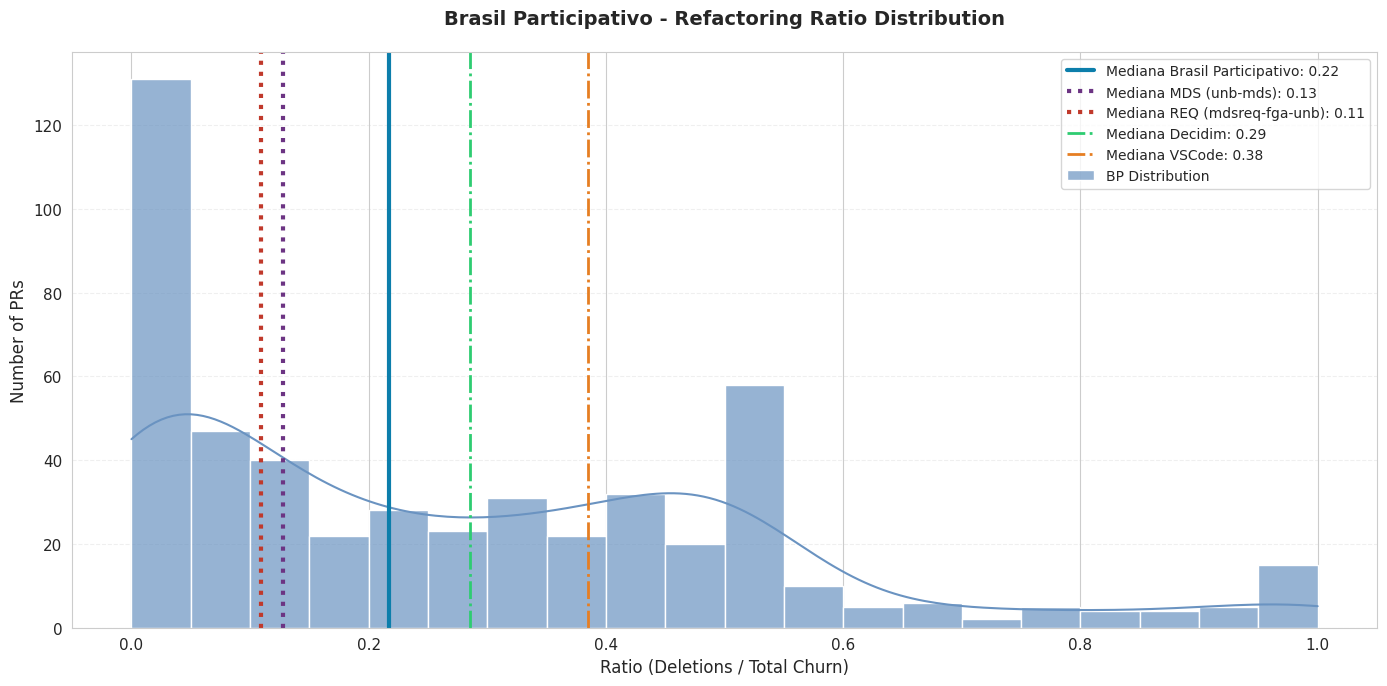

In [60]:
def plot_maintenance_patterns_comparison(df_bp, df_mds, df_req):
    def calculate_ratio(data):
        temp = data.copy()
        temp['refactor_ratio'] = temp.apply(lambda x: x['deletions'] / x['churn'] if x['churn'] > 0 else 0, axis=1)
        return temp

    df_bp_final = calculate_ratio(df_bp)
    df_mds_final = calculate_ratio(df_mds)
    df_req_final = calculate_ratio(df_req)
    df_decidim_final = calculate_ratio(df_decidim)
    df_vscode_final = calculate_ratio(df_vscode)

    # Calcular medianas
    med_bp = df_bp_final['refactor_ratio'].median()
    med_mds = df_mds_final['refactor_ratio'].median()
    med_req = df_req_final['refactor_ratio'].median()
    med_decidim = df_decidim_final['refactor_ratio'].median()
    med_vscode = df_vscode_final['refactor_ratio'].median()

    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Histograma principal do Brasil Participativo
    sns.histplot(df_bp_final['refactor_ratio'], kde=True, color=BP_LIGHT, edgecolor='white', 
                 bins=20, ax=ax, alpha=0.7, label='BP Distribution')
    
    # Linhas verticais das medianas
    ax.axvline(med_bp, color=BP_PRIMARY, linewidth=3, label=f'Mediana {org_title}: {med_bp:.2f}')
    ax.axvline(med_mds, color=MDS_PRIMARY, linewidth=3, linestyle=':', label=f'Mediana {mds_title}: {med_mds:.2f}')
    ax.axvline(med_req, color=REQ_PRIMARY, linewidth=3, linestyle=':', label=f'Mediana {req_title}: {med_req:.2f}')
    ax.axvline(med_decidim, color=REF_DECIDIM, linewidth=2, linestyle='-.', label=f'Mediana Decidim: {med_decidim:.2f}')
    ax.axvline(med_vscode, color=REF_VSCODE, linewidth=2, linestyle='-.', label=f'Mediana VSCode: {med_vscode:.2f}')
    
    ax.set_title(f'{org_title} - Refactoring Ratio Distribution', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Ratio (Deletions / Total Churn)', fontsize=12)
    ax.set_ylabel('Number of PRs', fontsize=12)
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_maintenance_patterns_comparison(df, df_mds, df_req)

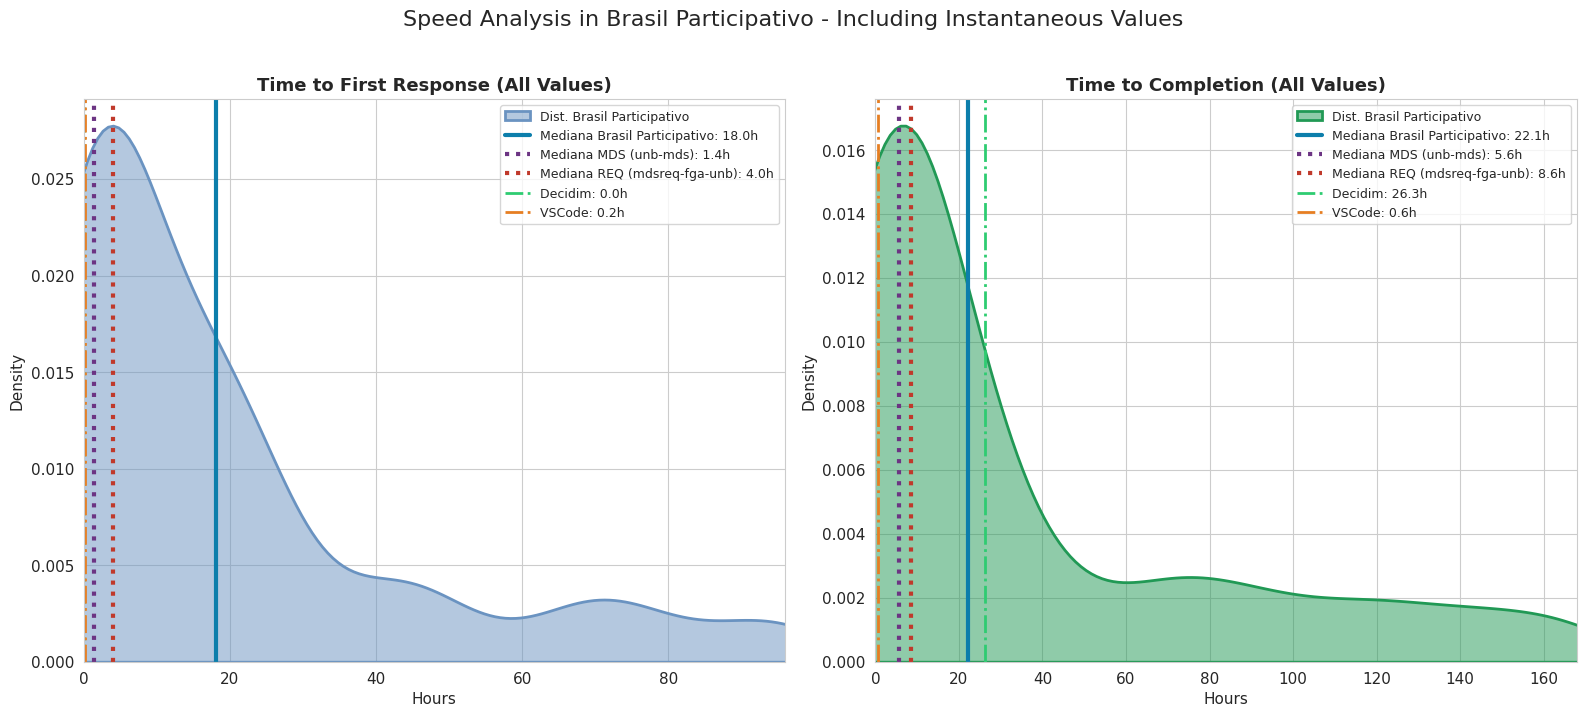

In [70]:
def plot_review_speed_all_values(df_lab, df_mds, df_req, lab_label="BP", mds_label="MDS", req_label="Req"):
    """
    Plota análise de velocidade de review MANTENDO TODOS OS VALORES, inclusive os instantâneos (<0.01h).
    Não aplica a filtragem temporal que remove valores muito baixos.
    """
    df_lab_rev = df_lab[df_lab['reviewers'].notna() & (df_lab['reviewers'] != "")].copy()
    df_mds_rev = df_mds[df_mds['reviewers'].notna() & (df_mds['reviewers'] != "")].copy()
    df_req_rev = df_req[df_req['reviewers'].notna() & (df_req['reviewers'] != "")].copy()
    df_decidim_rev = df_decidim[df_decidim['reviewers'].notna() & (df_decidim['reviewers'] != "")].copy()
    df_vscode_rev = df_vscode[df_vscode['reviewers'].notna() & (df_vscode['reviewers'] != "")].copy()

    clean_resp_lab = df_lab_rev['time_to_first_review_hours']
    clean_comp_lab = df_lab_rev['lead_time_hours']
    clean_resp_mds = df_mds_rev['time_to_first_review_hours']
    clean_comp_mds = df_mds_rev['lead_time_hours']
    clean_resp_req = df_req_rev['time_to_first_review_hours']
    clean_comp_req = df_req_rev['lead_time_hours']
    clean_resp_decidim = df_decidim_rev['time_to_first_review_hours']
    clean_comp_decidim = df_decidim_rev['lead_time_hours']
    clean_resp_vscode = df_vscode_rev['time_to_first_review_hours']
    clean_comp_vscode = df_vscode_rev['lead_time_hours']
    
    viz_resp_lab = clean_resp_lab[clean_resp_lab <= 96]
    viz_comp_lab = clean_comp_lab[clean_comp_lab <= 168]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    sns.kdeplot(viz_resp_lab, fill=True, color=BP_LIGHT, alpha=0.5, linewidth=2, ax=ax1, label=f'Dist. {lab_label}')
    
    med_resp_lab = clean_resp_lab.median()
    med_resp_mds = clean_resp_mds.median()
    med_resp_req = clean_resp_req.median()
    med_resp_decidim = clean_resp_decidim.median()
    med_resp_vscode = clean_resp_vscode.median()
    
    ax1.axvline(med_resp_lab, color=BP_PRIMARY, linewidth=3, label=f'Mediana {lab_label}: {med_resp_lab:.1f}h')
    ax1.axvline(med_resp_mds, color=MDS_PRIMARY, linewidth=3, linestyle=':', label=f'Mediana {mds_label}: {med_resp_mds:.1f}h')
    ax1.axvline(med_resp_req, color=REQ_PRIMARY, linewidth=3, linestyle=':', label=f'Mediana {req_label}: {med_resp_req:.1f}h')
    ax1.axvline(med_resp_decidim, color=REF_DECIDIM, linewidth=2, linestyle='-.', label=f'Decidim: {med_resp_decidim:.1f}h')
    ax1.axvline(med_resp_vscode, color=REF_VSCODE, linewidth=2, linestyle='-.', label=f'VSCode: {med_resp_vscode:.1f}h')
    ax1.set_title('Time to First Response (All Values)', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Hours')
    ax1.set_xlim(0, 96)
    ax1.legend(fontsize=9)

    sns.kdeplot(viz_comp_lab, fill=True, color=BP_SECONDARY, alpha=0.5, linewidth=2, ax=ax2, label=f'Dist. {lab_label}')
    
    med_comp_lab = clean_comp_lab.median()
    med_comp_mds = clean_comp_mds.median()
    med_comp_req = clean_comp_req.median()
    med_comp_decidim = clean_comp_decidim.median()
    med_comp_vscode = clean_comp_vscode.median()
    
    ax2.axvline(med_comp_lab, color=BP_PRIMARY, linewidth=3, label=f'Mediana {lab_label}: {med_comp_lab:.1f}h')
    ax2.axvline(med_comp_mds, color=MDS_PRIMARY, linewidth=3, linestyle=':', label=f'Mediana {mds_label}: {med_comp_mds:.1f}h')
    ax2.axvline(med_comp_req, color=REQ_PRIMARY, linewidth=3, linestyle=':', label=f'Mediana {req_label}: {med_comp_req:.1f}h')
    ax2.axvline(med_comp_decidim, color=REF_DECIDIM, linewidth=2, linestyle='-.', label=f'Decidim: {med_comp_decidim:.1f}h')
    ax2.axvline(med_comp_vscode, color=REF_VSCODE, linewidth=2, linestyle='-.', label=f'VSCode: {med_comp_vscode:.1f}h')
    ax2.set_title('Time to Completion (All Values)', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Hours')
    ax2.set_xlim(0, 168)
    ax2.legend(fontsize=9)
    
    plt.suptitle(f"Speed Analysis in {lab_label} - Including Instantaneous Values", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

plot_review_speed_all_values(df, df_mds, df_req, lab_label=org_title, mds_label=mds_title, req_label=req_title)

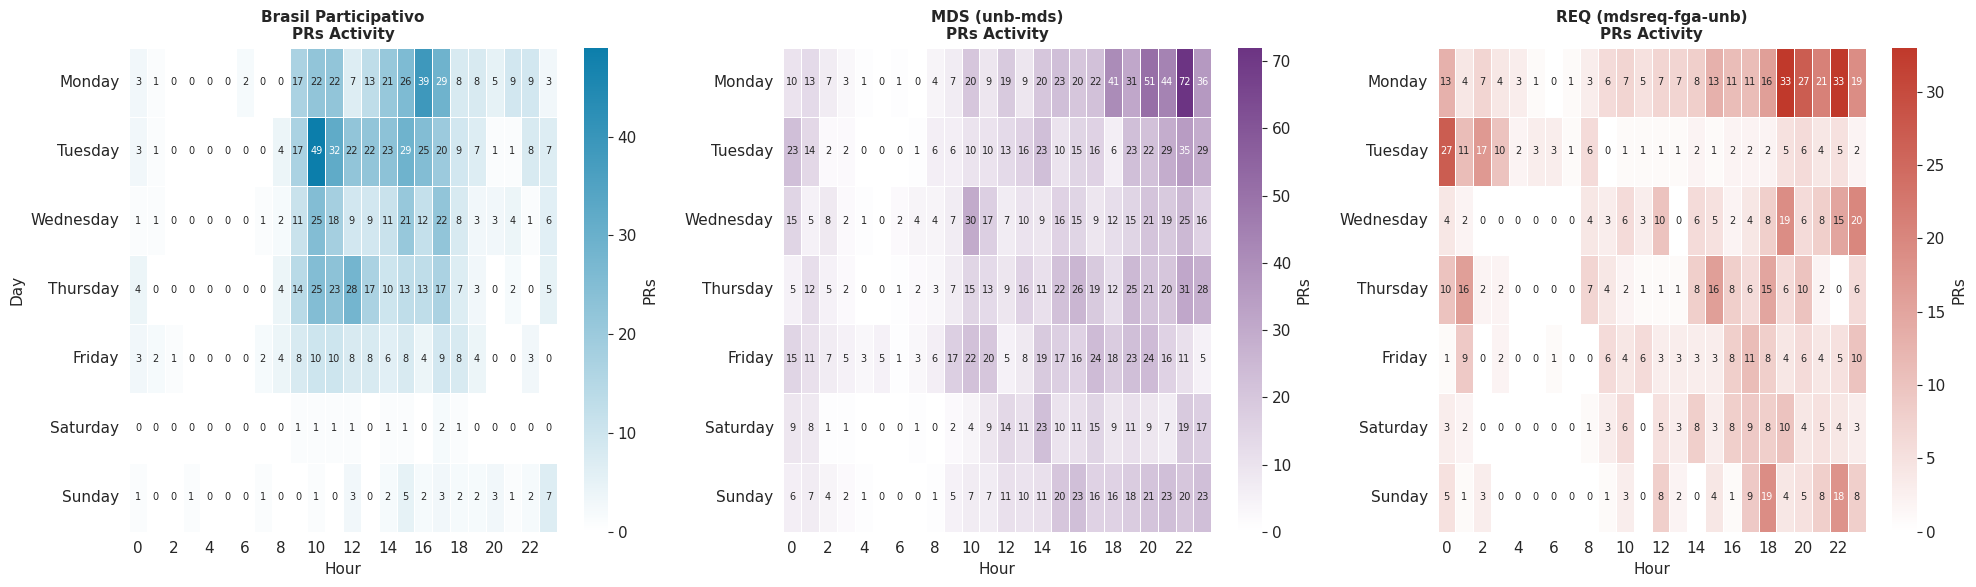

In [58]:
from matplotlib.colors import LinearSegmentedColormap

def plot_activity_heatmaps_comparison(df_bp, df_mds, df_req):
    def prepare_data(data):
        data = data.copy()
        data['created_at'] = pd.to_datetime(data['created_at'], utc=True)
        data['merged_at'] = pd.to_datetime(data['merged_at'], utc=True)
        try:
            data['created_at_br'] = data['created_at'].dt.tz_convert('America/Sao_Paulo')
            data['merged_at_br'] = data['merged_at'].dt.tz_convert('America/Sao_Paulo')
        except:
            data['created_at_br'] = data['created_at']
            data['merged_at_br'] = data['merged_at']
        return data

    def get_combined_heatmap_data(data):
        # Combina eventos de created_at e merged_at
        temp_created = data[['id', 'created_at_br']].dropna().copy()
        temp_created['day_name'] = temp_created['created_at_br'].dt.day_name()
        temp_created['hour'] = temp_created['created_at_br'].dt.hour
        
        temp_merged = data[['id', 'merged_at_br']].dropna().copy()
        temp_merged['day_name'] = temp_merged['merged_at_br'].dt.day_name()
        temp_merged['hour'] = temp_merged['merged_at_br'].dt.hour
        
        # Concatena os dois DataFrames
        temp_combined = pd.concat([
            temp_created[['day_name', 'hour']], 
            temp_merged[['day_name', 'hour']]
        ])
        
        pivot = temp_combined.groupby(['day_name', 'hour']).size().unstack(fill_value=0)
        days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        pivot = pivot.reindex(days_order).fillna(0).astype(int)
        for h in range(24):
            if h not in pivot.columns:
                pivot[h] = 0
        return pivot[sorted(pivot.columns)]

    # Criação dos Colormaps baseados nas variáveis
    cmap_bp = LinearSegmentedColormap.from_list("bp", ["#ffffff", BP_PRIMARY])
    cmap_mds = LinearSegmentedColormap.from_list("mds", ["#ffffff", MDS_PRIMARY])
    cmap_req = LinearSegmentedColormap.from_list("req", ["#ffffff", REQ_PRIMARY])

    df_bp = prepare_data(df_bp)
    df_mds = prepare_data(df_mds)
    df_req = prepare_data(df_req)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # PRs Activity combinando opened + merged
    sns.heatmap(get_combined_heatmap_data(df_bp), cmap=cmap_bp, annot=True, fmt='d', linewidths=.5, ax=axes[0], cbar_kws={'label': 'PRs'}, annot_kws={'size': 7})
    axes[0].set_title(f'{org_title}\nPRs Activity', fontsize=11, fontweight='bold')
    
    sns.heatmap(get_combined_heatmap_data(df_mds), cmap=cmap_mds, annot=True, fmt='d', linewidths=.5, ax=axes[1], cbar_kws={'label': 'PRs'}, annot_kws={'size': 7})
    axes[1].set_title(f'{mds_title}\nPRs Activity', fontsize=11, fontweight='bold')
    
    sns.heatmap(get_combined_heatmap_data(df_req), cmap=cmap_req, annot=True, fmt='d', linewidths=.5, ax=axes[2], cbar_kws={'label': 'PRs'}, annot_kws={'size': 7})
    axes[2].set_title(f'{req_title}\nPRs Activity', fontsize=11, fontweight='bold')

    # Ajustes de Labels
    for ax in axes.flat:
        ax.set_ylabel('')
        ax.set_xlabel('Hour')
    
    axes[0].set_ylabel('Day')

    plt.tight_layout()
    plt.show()

plot_activity_heatmaps_comparison(df, df_mds, df_req)

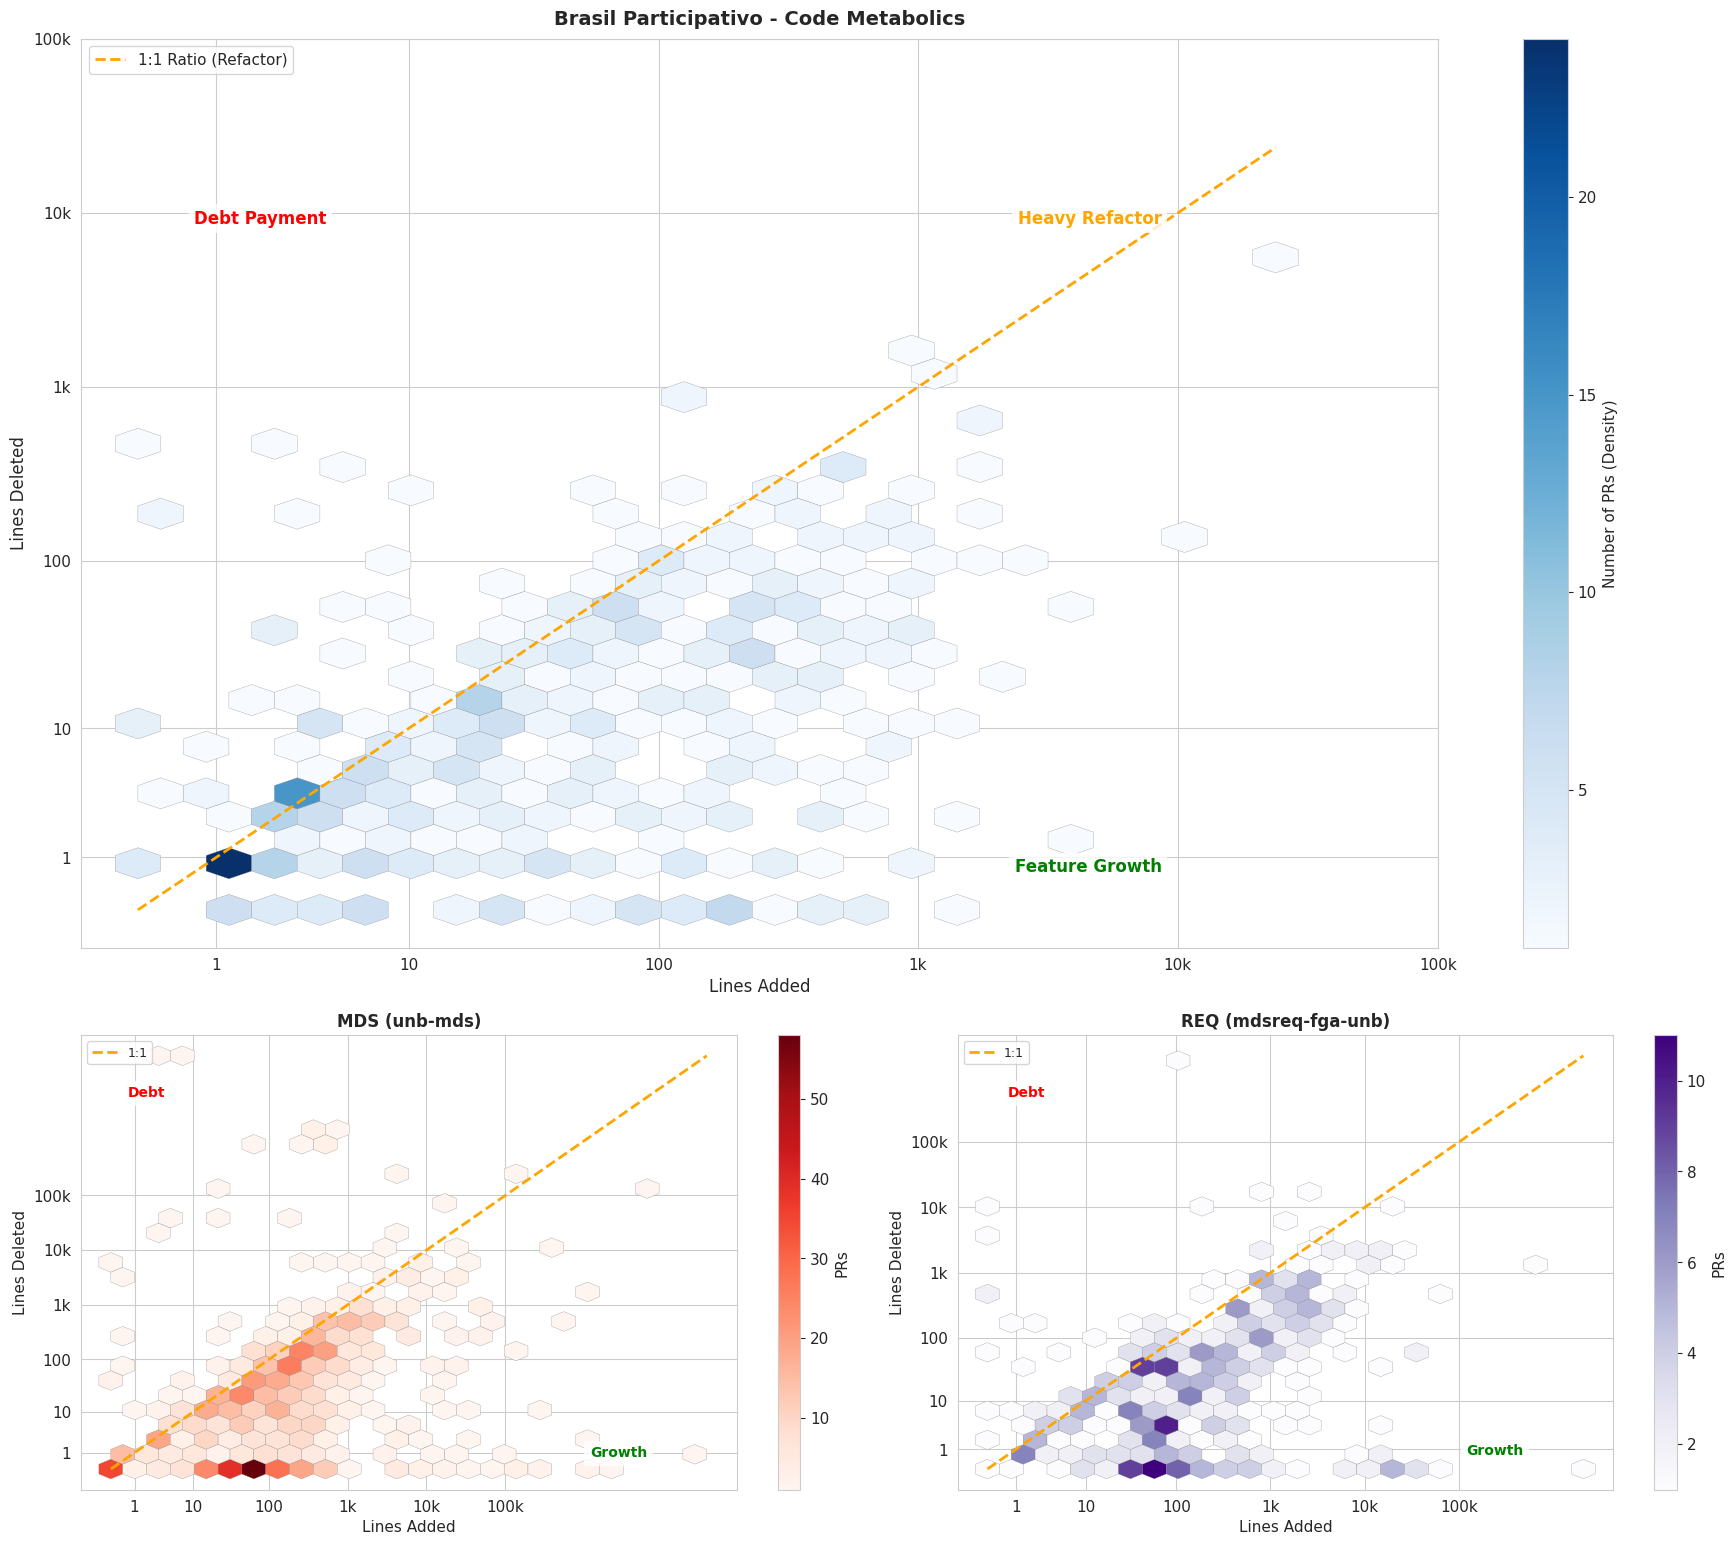

In [59]:
def plot_code_metabolics_all():
    from matplotlib.gridspec import GridSpec
    
    fig = plt.figure(figsize=(18, 16))
    gs = GridSpec(3, 2, figure=fig, height_ratios=[2, 1, 0], width_ratios=[1, 1])
    
    # Brasil Participativo
    ax1 = fig.add_subplot(gs[0, :])
    x_bp = np.log1p(df['additions'])
    y_bp = np.log1p(df['deletions'])
    hb1 = ax1.hexbin(x_bp, y_bp, gridsize=25, cmap='Blues', mincnt=1, edgecolors='gray', linewidths=0.2)
    plt.colorbar(hb1, ax=ax1, label='Number of PRs (Density)')
    max_val_bp = max(x_bp.max(), y_bp.max())
    ax1.plot([0, max_val_bp], [0, max_val_bp], '--', color='orange', linewidth=2, label='1:1 Ratio (Refactor)')
    ticks = [1, 10, 100, 1000, 10000, 100000]
    log_ticks = np.log1p(ticks)
    labels = ['1', '10', '100', '1k', '10k', '100k']
    ax1.set_xticks(log_ticks)
    ax1.set_xticklabels(labels)
    ax1.set_yticks(log_ticks)
    ax1.set_yticklabels(labels)
    ax1.text(max_val_bp * 0.9, 0.5, 'Feature Growth', color='green', fontweight='bold', ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax1.text(0.5, max_val_bp * 0.9, 'Debt Payment', color='red', fontweight='bold', ha='left', fontsize=12, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax1.text(max_val_bp * 0.9, max_val_bp * 0.9, 'Heavy Refactor', color='orange', fontweight='bold', ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax1.set_title(f'{org_title} - Code Metabolics', fontsize=14, fontweight='bold', pad=10)
    ax1.set_xlabel('Lines Added', fontsize=12)
    ax1.set_ylabel('Lines Deleted', fontsize=12)
    ax1.legend(loc='upper left')
    
    # MDS 
    ax2 = fig.add_subplot(gs[1, 0])
    x_mds = np.log1p(df_mds['additions'])
    y_mds = np.log1p(df_mds['deletions'])
    hb2 = ax2.hexbin(x_mds, y_mds, gridsize=25, cmap='Reds', mincnt=1, edgecolors='gray', linewidths=0.2)
    plt.colorbar(hb2, ax=ax2, label='PRs')
    max_val_mds = max(x_mds.max(), y_mds.max())
    ax2.plot([0, max_val_mds], [0, max_val_mds], '--', color='orange', linewidth=2, label='1:1')
    ax2.set_xticks(log_ticks)
    ax2.set_xticklabels(labels)
    ax2.set_yticks(log_ticks)
    ax2.set_yticklabels(labels)
    ax2.text(max_val_mds * 0.9, 0.5, 'Growth', color='green', fontweight='bold', ha='right', fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax2.text(0.5, max_val_mds * 0.9, 'Debt', color='red', fontweight='bold', ha='left', fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax2.set_title(f'{mds_title}', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Lines Added', fontsize=11)
    ax2.set_ylabel('Lines Deleted', fontsize=11)
    ax2.legend(loc='upper left', fontsize=9)
    
    # Requisitos 
    ax3 = fig.add_subplot(gs[1, 1])
    x_req = np.log1p(df_req['additions'])
    y_req = np.log1p(df_req['deletions'])
    hb3 = ax3.hexbin(x_req, y_req, gridsize=25, cmap='Purples', mincnt=1, edgecolors='gray', linewidths=0.2)
    plt.colorbar(hb3, ax=ax3, label='PRs')
    max_val_req = max(x_req.max(), y_req.max())
    ax3.plot([0, max_val_req], [0, max_val_req], '--', color='orange', linewidth=2, label='1:1')
    ax3.set_xticks(log_ticks)
    ax3.set_xticklabels(labels)
    ax3.set_yticks(log_ticks)
    ax3.set_yticklabels(labels)
    ax3.text(max_val_req * 0.9, 0.5, 'Growth', color='green', fontweight='bold', ha='right', fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax3.text(0.5, max_val_req * 0.9, 'Debt', color='red', fontweight='bold', ha='left', fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax3.set_title(f'{req_title}', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Lines Added', fontsize=11)
    ax3.set_ylabel('Lines Deleted', fontsize=11)
    ax3.legend(loc='upper left', fontsize=9)
    
    plt.tight_layout()
    plt.show()

plot_code_metabolics_all()

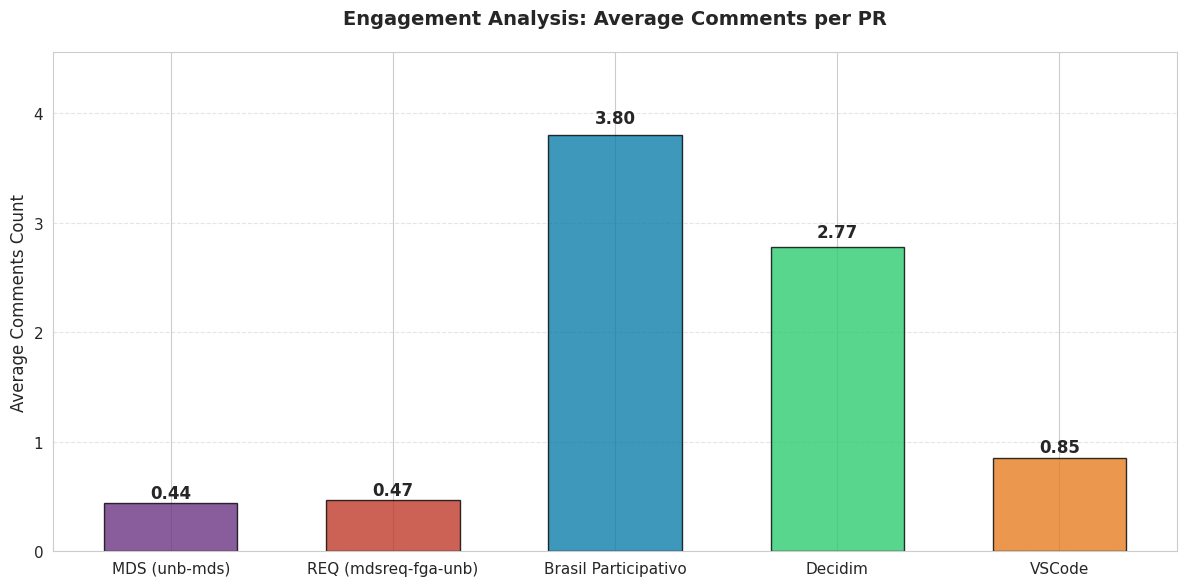

In [65]:
avg_comments_bp = df['comments'].mean()
avg_comments_mds = df_mds['comments'].mean()
avg_comments_req = df_req['comments'].mean()
avg_comments_decidim = df_decidim['comments'].mean()
avg_comments_vscode = df_vscode['comments'].mean()

x_labels = [mds_title, req_title, org_title, 'Decidim', 'VSCode']
y_values = [avg_comments_mds, avg_comments_req, avg_comments_bp, avg_comments_decidim, avg_comments_vscode]
bar_colors = [MDS_PRIMARY, REQ_PRIMARY, BP_PRIMARY, REF_DECIDIM, REF_VSCODE]

plt.figure(figsize=(12, 6))
bars = plt.bar(x_labels, y_values, color=bar_colors, width=0.6, edgecolor='black', alpha=0.8)

plt.title('Engagement Analysis: Average Comments per PR', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Average Comments Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (height * 0.02), f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim(0, max(y_values) * 1.2)
plt.tight_layout()
plt.show()

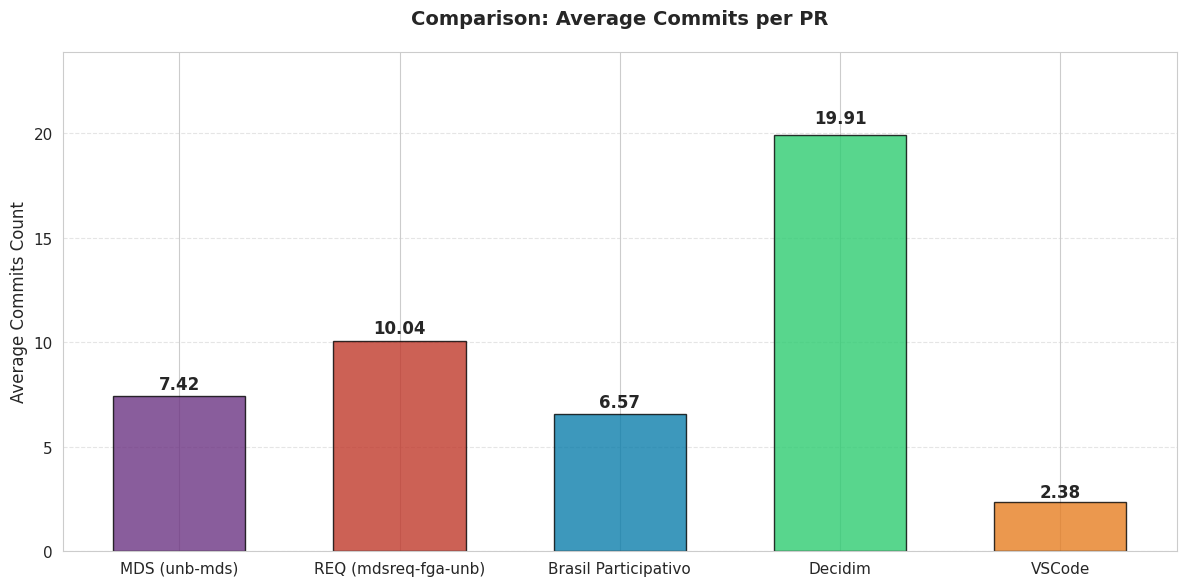

In [64]:
avg_commits_bp = df['commits'].mean()
avg_commits_mds = df_mds['commits'].mean()
avg_commits_req = df_req['commits'].mean()
avg_commits_decidim = df_decidim['commits'].mean()
avg_commits_vscode = df_vscode['commits'].mean()

x_labels = [mds_title, req_title, org_title, 'Decidim', 'VSCode']
y_values = [avg_commits_mds, avg_commits_req, avg_commits_bp, avg_commits_decidim, avg_commits_vscode]
bar_colors = [MDS_PRIMARY, REQ_PRIMARY, BP_PRIMARY, REF_DECIDIM, REF_VSCODE]

plt.figure(figsize=(12, 6))
bars = plt.bar(x_labels, y_values, color=bar_colors, width=0.6, edgecolor='black', alpha=0.8)

plt.title('Comparison: Average Commits per PR', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Average Commits Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (height * 0.02), f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim(0, max(y_values) * 1.2)
plt.tight_layout()
plt.show()

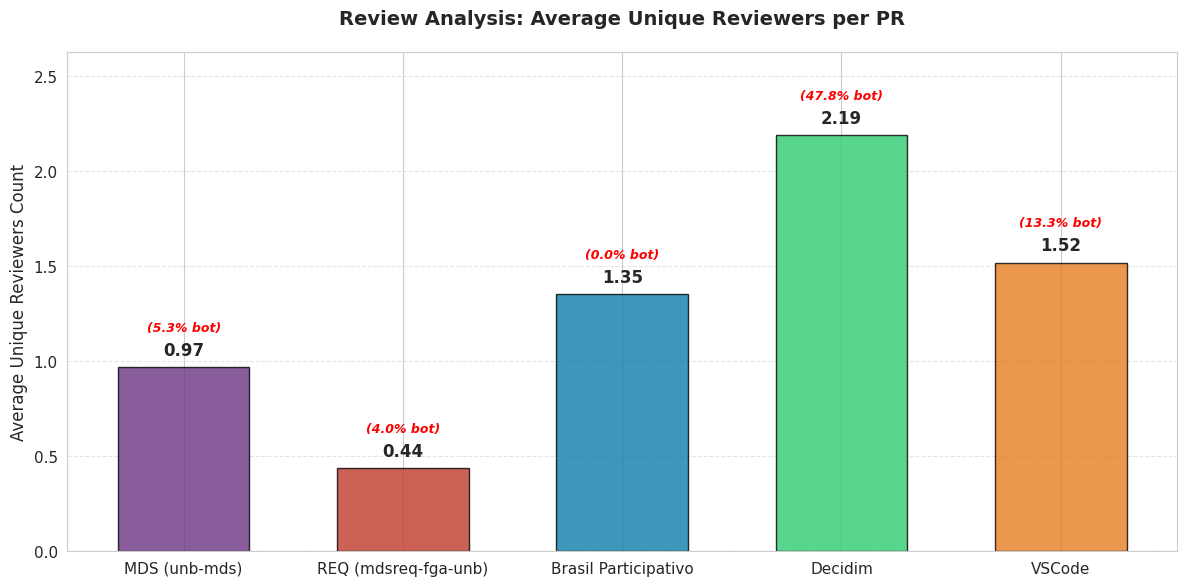

In [63]:
def count_unique_reviewers(reviewers_str):
    if pd.isna(reviewers_str) or reviewers_str == "":
        return 0
    return len(str(reviewers_str).split(','))

def count_bot_reviewers(reviewers_str):
    """Conta quantos reviewers são bots"""
    if pd.isna(reviewers_str) or reviewers_str == "":
        return 0
    bot_keywords = ['github-actions', 'github-advanced-security', 'copilot-pull-request-reviewer', 
                    'dependabot', 'renovate', 'codecov']
    reviewers = [r.strip().lower() for r in str(reviewers_str).split(',')]
    return sum(1 for r in reviewers if any(bot in r for bot in bot_keywords))

# Calcular média de reviewers únicos para cada organização
df['num_reviewers'] = df['reviewers'].apply(count_unique_reviewers)
df_mds['num_reviewers'] = df_mds['reviewers'].apply(count_unique_reviewers)
df_req['num_reviewers'] = df_req['reviewers'].apply(count_unique_reviewers)
df_decidim['num_reviewers'] = df_decidim['reviewers'].apply(count_unique_reviewers)
df_vscode['num_reviewers'] = df_vscode['reviewers'].apply(count_unique_reviewers)

# Calcular média de bot reviewers para cada organização
df_rev_bp = df[df['reviewers'].notna() & (df['reviewers'] != "")].copy()
df_rev_mds = df_mds[df_mds['reviewers'].notna() & (df_mds['reviewers'] != "")].copy()
df_rev_req = df_req[df_req['reviewers'].notna() & (df_req['reviewers'] != "")].copy()
df_rev_decidim = df_decidim[df_decidim['reviewers'].notna() & (df_decidim['reviewers'] != "")].copy()
df_rev_vscode = df_vscode[df_vscode['reviewers'].notna() & (df_vscode['reviewers'] != "")].copy()

bot_reviewers_bp = df_rev_bp['reviewers'].apply(count_bot_reviewers).mean()
bot_reviewers_mds = df_rev_mds['reviewers'].apply(count_bot_reviewers).mean()
bot_reviewers_req = df_rev_req['reviewers'].apply(count_bot_reviewers).mean()
bot_reviewers_decidim = df_rev_decidim['reviewers'].apply(count_bot_reviewers).mean()
bot_reviewers_vscode = df_rev_vscode['reviewers'].apply(count_bot_reviewers).mean()

avg_unique_reviewers_bp = df['num_reviewers'].mean()
avg_unique_reviewers_mds = df_mds['num_reviewers'].mean()
avg_unique_reviewers_req = df_req['num_reviewers'].mean()
avg_unique_reviewers_decidim = df_decidim['num_reviewers'].mean()
avg_unique_reviewers_vscode = df_vscode['num_reviewers'].mean()

x_labels = [mds_title, req_title, org_title, 'Decidim', 'VSCode']
total_values = [avg_unique_reviewers_mds, avg_unique_reviewers_req, avg_unique_reviewers_bp,
                avg_unique_reviewers_decidim, avg_unique_reviewers_vscode]
bot_values = [bot_reviewers_mds, bot_reviewers_req, bot_reviewers_bp,
              bot_reviewers_decidim, bot_reviewers_vscode]
bar_colors = [MDS_PRIMARY, REQ_PRIMARY, BP_PRIMARY, REF_DECIDIM, REF_VSCODE]

plt.figure(figsize=(12, 6))
bars = plt.bar(x_labels, total_values, color=bar_colors, width=0.6, edgecolor='black', alpha=0.8)

plt.title('Review Analysis: Average Unique Reviewers per PR', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Average Unique Reviewers Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for i, (bar, total, bot) in enumerate(zip(bars, total_values, bot_values)):
    height = bar.get_height()
    # Valor total
    plt.text(bar.get_x() + bar.get_width()/2., height + (max(total_values) * 0.02), 
             f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Porcentagem de bot
    bot_pct = (bot / total * 100) if total > 0 else 0
    plt.text(bar.get_x() + bar.get_width()/2., height + (max(total_values) * 0.08), 
             f'({bot_pct:.1f}% bot)', ha='center', va='bottom', fontsize=9, 
             color='red', style='italic', fontweight='bold')

plt.ylim(0, max(total_values) * 1.2)

plt.tight_layout()
plt.show()

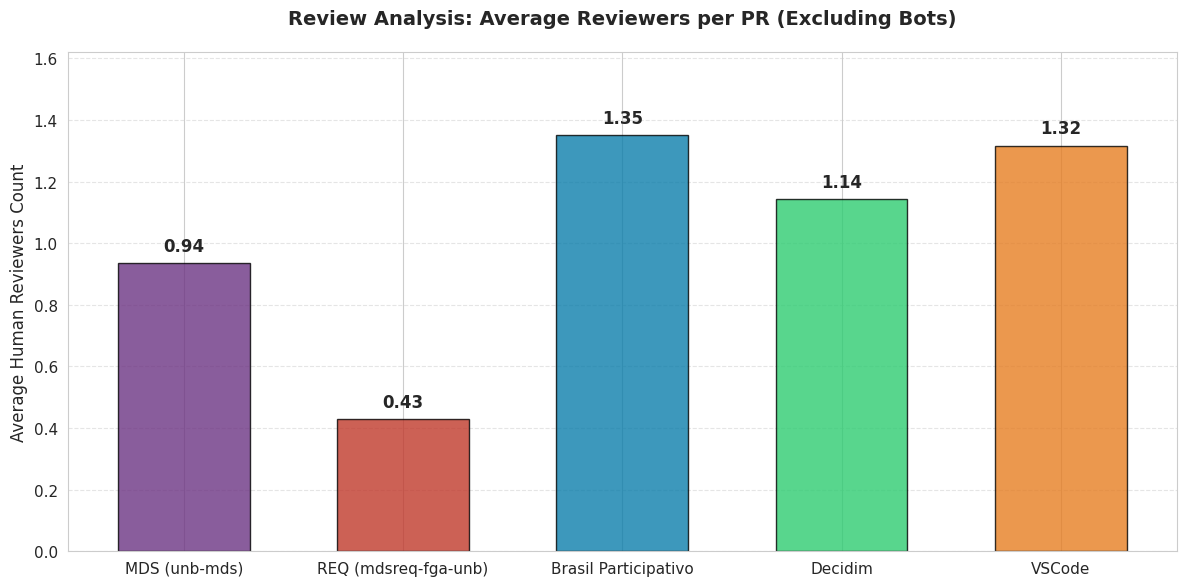

In [71]:
# Gráfico de reviewers únicos EXCLUINDO BOTS
def count_human_reviewers(reviewers_str):
    """Conta apenas reviewers humanos (exclui bots conhecidos)"""
    if pd.isna(reviewers_str) or reviewers_str == "":
        return 0
    
    bot_keywords = ['github-actions', 'github-advanced-security', 'copilot-pull-request-reviewer', 
                    'dependabot', 'renovate', 'codecov']
    
    reviewers = [r.strip() for r in str(reviewers_str).split(',')]
    human_reviewers = [r for r in reviewers if not any(bot.lower() in r.lower() for bot in bot_keywords)]
    return len(human_reviewers)

# Calcular média de reviewers HUMANOS para cada organização
df['num_human_reviewers'] = df['reviewers'].apply(count_human_reviewers)
df_mds['num_human_reviewers'] = df_mds['reviewers'].apply(count_human_reviewers)
df_req['num_human_reviewers'] = df_req['reviewers'].apply(count_human_reviewers)
df_decidim['num_human_reviewers'] = df_decidim['reviewers'].apply(count_human_reviewers)
df_vscode['num_human_reviewers'] = df_vscode['reviewers'].apply(count_human_reviewers)

avg_human_reviewers_bp = df['num_human_reviewers'].mean()
avg_human_reviewers_mds = df_mds['num_human_reviewers'].mean()
avg_human_reviewers_req = df_req['num_human_reviewers'].mean()
avg_human_reviewers_decidim = df_decidim['num_human_reviewers'].mean()
avg_human_reviewers_vscode = df_vscode['num_human_reviewers'].mean()

x_labels = [mds_title, req_title, org_title, 'Decidim', 'VSCode']
y_values_human = [avg_human_reviewers_mds, avg_human_reviewers_req, avg_human_reviewers_bp,
                  avg_human_reviewers_decidim, avg_human_reviewers_vscode]
bar_colors = [MDS_PRIMARY, REQ_PRIMARY, BP_PRIMARY, REF_DECIDIM, REF_VSCODE]

plt.figure(figsize=(12, 6))
bars = plt.bar(x_labels, y_values_human, color=bar_colors, width=0.6, edgecolor='black', alpha=0.8)

plt.title('Review Analysis: Average Reviewers per PR (Excluding Bots)', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Average Human Reviewers Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar, value in zip(bars, y_values_human):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (max(y_values_human) * 0.02), 
             f'{value:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim(0, max(y_values_human) * 1.2)
plt.tight_layout()
plt.show()



 <img src="assets/grafo.png" width="1000" />